# Final Project: WikiArt Style Classification at varying network depth
## CSC 594: Advanced Deep Learning
## Ross Pollock

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras 
import tensorflow.keras.layers as L

import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder, StandardScaler

from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
# Extract Data to local colab drive
! tar xfz /drive/My\ Drive/CSC594/Data/Image/wikiart.tar.gz -C /content/

tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 

In [ ]:
def plot_training_history(
    history: keras.callbacks.History
) -> None: 
  n_epochs = len(history.history['val_loss'])
  fig, axs = plt.subplots(ncols=2,figsize=(16,8))

  sns.lineplot(
      x=list(range(1,n_epochs+1)),y=history.history['val_accuracy'],
      ax=axs[0],label='Validation'
  )
  sns.lineplot(
      x=list(range(1,n_epochs+1)),y=history.history['accuracy'],
      ax=axs[0],label='Training'
  )

  sns.lineplot(
      x=list(range(1,n_epochs+1)),y=history.history['val_loss'],
      ax=axs[1],label='Validation'
  )
  sns.lineplot(
      x=list(range(1,n_epochs+1)),y=history.history['loss'],
      ax=axs[1],label='Training'
  ) 
  

  axs[0].set_title('Model Accuracy')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Accuracy')
  axs[1].set_title('Model Loss')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Loss')

  plt.suptitle('Model Training')
  plt.show()


####################################
# Image Preprocessing Functions 
@tf.function
def smart_resize(img,size=244):
  h,w = tf.shape(img)[0], tf.shape(img)[1]
  min_dim = tf.minimum(h,w)
  ratio = size / tf.cast(min_dim,tf.float32) 

  new_w = tf.cast(w,tf.float32) * ratio
  new_h = tf.cast(h,tf.float32) * ratio

  img = tf.image.resize(img,[new_h,new_w],preserve_aspect_ratio=True)
  img = tf.image.resize_with_crop_or_pad(img,size,size)
  return img

@tf.function
def img_preprocess(fpath):
    img = tf.io.read_file(fpath)
    img = tf.image.decode_jpeg(img,3)
    img = tf.cast(img,tf.float32)
    img = smart_resize(img,size=244)
    img /= (255/2)
    img -= 1 
    return img 
####################################

####################################
def prep_ds(file_paths,preprocesser=img_preprocess,batch_size=128):
  ''' 
  Prepare dataset for linear evaluation
  '''
  ds = tf.data.Dataset.from_tensor_slices(file_paths)
  ds = ds.map(preprocesser,tf.data.experimental.AUTOTUNE)
  ds = ds.batch(batch_size)
  return ds

def prep_with_labels(file_paths,labels,preprocesser=img_preprocess,train=False,repeat=False):
  '''
  Prepare dataset for fine tuning
  '''
  ds_img = tf.data.Dataset.from_tensor_slices(file_paths)
  ds_img = ds_img.map(preprocesser,tf.data.experimental.AUTOTUNE)
  ds_labels = tf.data.Dataset.from_tensor_slices(labels)
  ds = tf.data.Dataset.zip((ds_img,ds_labels))
  if train:
    ds = ds.shuffle(1000)
  if repeat:
    ds = ds.repeat()
  return ds
####################################

####################################
# Model builder for less deep representations
def model_depth_builder(cnn,layer_name,pooling='avg'):
  model_input = cnn.inputs 
  conv_out = cnn.get_layer(layer_name).output

  if pooling == 'avg':
    pooling_layer = L.GlobalAveragePooling2D()
  elif pooling == 'max':
    pooling_layer = L.GlobalMaxPooling2D()

  pooled_conv = pooling_layer(conv_out)
  new_model = keras.Model(model_input,pooled_conv)
  return new_model
####################################

In [ ]:
def extract_representations(ds,cnn_model,n_samples,batch_size=128,with_labels=True):
  ds = ds.batch(batch_size)
  _, representation_dim = cnn_model.output_shape
  representations = np.zeros((n_samples,representation_dim))
  n_batches = n_samples.numpy() // batch_size + 1
  pbar = keras.utils.Progbar(n_batches)

  for i, batch in enumerate(ds):
    if with_labels:
      imgs, labels = batch
    else:
      imgs = batch
    reps = cnn_model(imgs,training=False)
    representations[i*batch_size:(i+1)*batch_size,:] = reps.numpy()
    pbar.update(i+1)

  return representations

In [ ]:
def linear_eval(
    cnn_model,train_set,test_set,n_classes,
    train_labels,test_labels,
    batch_size=128
  ):
  n_train_samples = train_set.cardinality()
  n_test_samples = test_set.cardinality()



  train_representations = extract_representations(train_set,cnn_model,n_train_samples,batch_size)
  test_representations = extract_representations(test_set,cnn_model,n_test_samples,batch_size)



  scaler = StandardScaler()
  scaled_train = scaler.fit_transform(train_representations)
  scaled_test = scaler.transform(test_representations)

  _, representation_dim = train_representations.shape

  softmax_clf = keras.Sequential(
      [
       L.Input(shape=(representation_dim,)),
       L.Dense(n_classes,'softmax')
      ]
  )

  softmax_clf.compile(
      keras.optimizers.Adam(),
      keras.losses.SparseCategoricalCrossentropy(),
      ['accuracy']
  )

  history = softmax_clf.fit(
      x = scaled_train, y = train_labels,
      epochs = 50, verbose = 0, validation_split = 0.1
  )

  plot_training_history(history)


  test_loss, test_acc = softmax_clf.evaluate(scaled_test,test_labels,verbose=0)

  print(f'Test Accuracy: {test_acc*100:0.2f}')

In [ ]:
####################################
# Read wikiart metadata
# Split into train and test splits
wikiart = pd.read_csv('/drive/My Drive/CSC594/Data/wikiart_labels.csv')

wikiart_train = wikiart[wikiart.train == 1]
wikiart_test  = wikiart[wikiart.train == 0]
wikiart_train_paths = wikiart_train.relative_path.to_list()
wikiart_train_paths = list(map(lambda x: '/content/wikiart_reduced/' + x,wikiart_train_paths))

wikiart_test_paths = wikiart_test.relative_path.to_list()
wikiart_test_paths = list(map(lambda x: '/content/wikiart_reduced/' + x,wikiart_test_paths))

wikiart_train_labels = wikiart_train.art_style.to_numpy()
wikiart_test_labels = wikiart_test.art_style.to_numpy()

n_train = len(wikiart_train_paths)
n_test = len(wikiart_test_paths)

# Encode String labels to integers 
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(wikiart_train_labels) 
y_test  = label_encoder.transform(wikiart_test_labels)
####################################

In [ ]:
ds_train = prep_with_labels(wikiart_train_paths,wikiart_train_labels)
ds_test = prep_with_labels(wikiart_test_paths,wikiart_test_labels)

### ResNet50 120k Pre-training Steps

In [ ]:
model_url = 'https://rosspollock.design/models/resnet50120.tar.gz'
keras.utils.get_file('model2',model_url,untar=True,extract=True)
encoder = keras.models.load_model('/root/.keras/datasets/query_encoder120k')
encoder = encoder.get_layer('resnet50')

103489536/103482239 [==============================] - 2s 0us/step


128/128 [==============================] - 90s 701ms/step


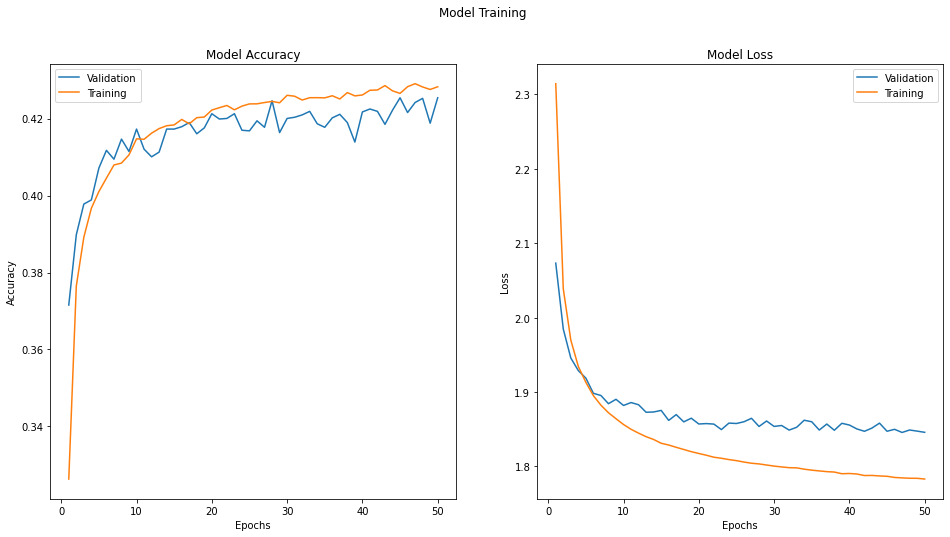

1.8434422016143799
0.42148557305336
Test Accuracy: 42.15
128/128 [==============================] - 100s 781ms/step


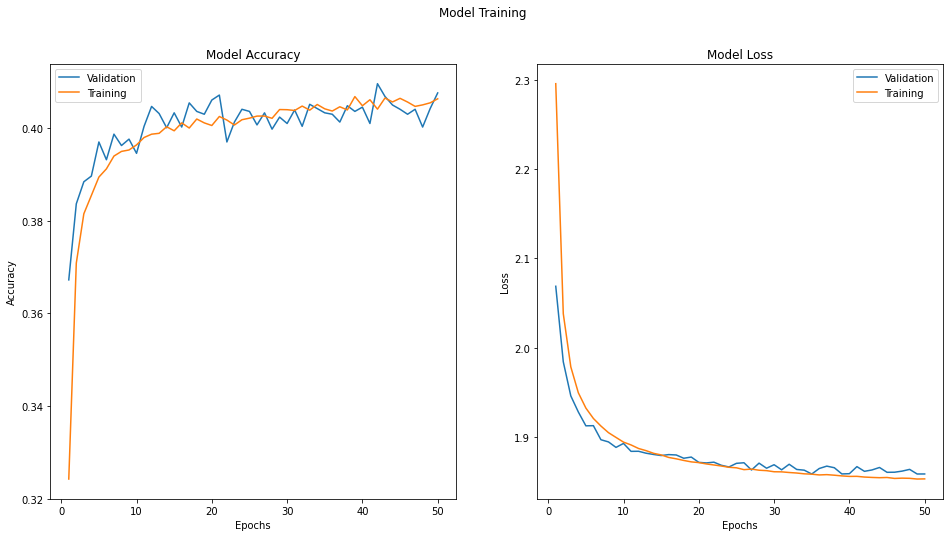

1.8665729761123657
0.4029465913772583
Test Accuracy: 40.29
128/128 [==============================] - 113s 882ms/step


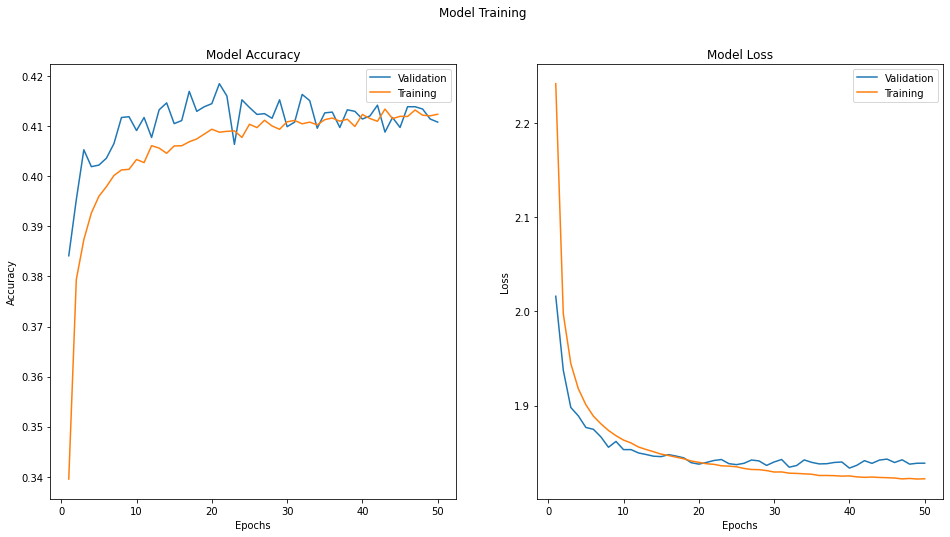

1.8355220556259155
0.40976059436798096
Test Accuracy: 40.98
128/128 [==============================] - 121s 945ms/step


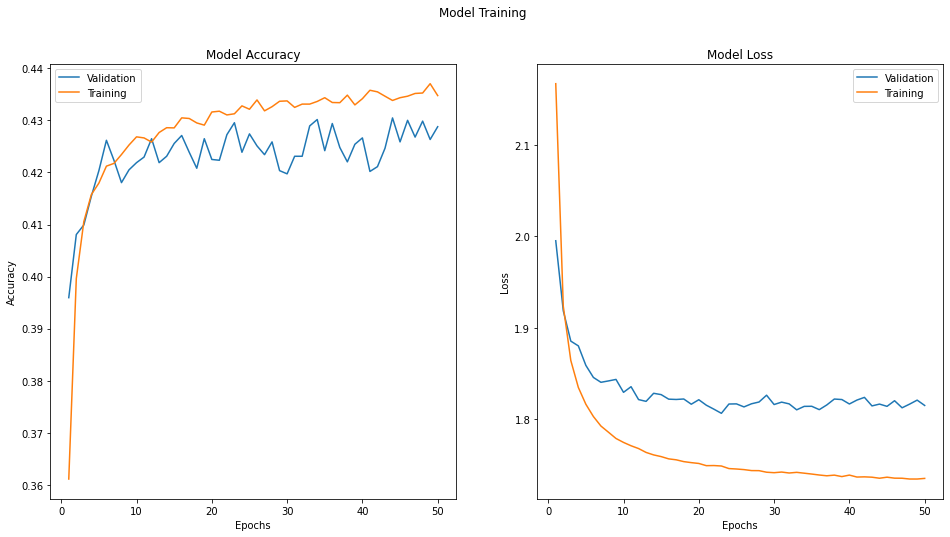

1.8653063774108887
0.42234498262405396
Test Accuracy: 42.23


In [ ]:
resnet_stack_out_layers = [
  'conv2_block3_out','conv3_block4_out',
  'conv4_block6_out','conv5_block3_out'
]

for layer in resnet_stack_out_layers:
  tmp_encoder = model_depth_builder(encoder,layer)

  linear_eval(
    tmp_encoder,ds_train,ds_test,
    n_classes=label_encoder.classes_.shape[0],
    train_labels = y_train, test_labels= y_test 
  )

### ResNet50 60k Pre-training Steps

In [ ]:
model_url = 'https://rosspollock.design/models/resnet5060.tar.gz'
keras.utils.get_file('model3',model_url,untar=True,extract=True)
encoder = keras.models.load_model('/root/.keras/datasets/query_encoder60k')
encoder = encoder.get_layer('resnet50')

103530496/103528310 [==============================] - 3s 0us/step


128/128 [==============================] - 82s 637ms/step


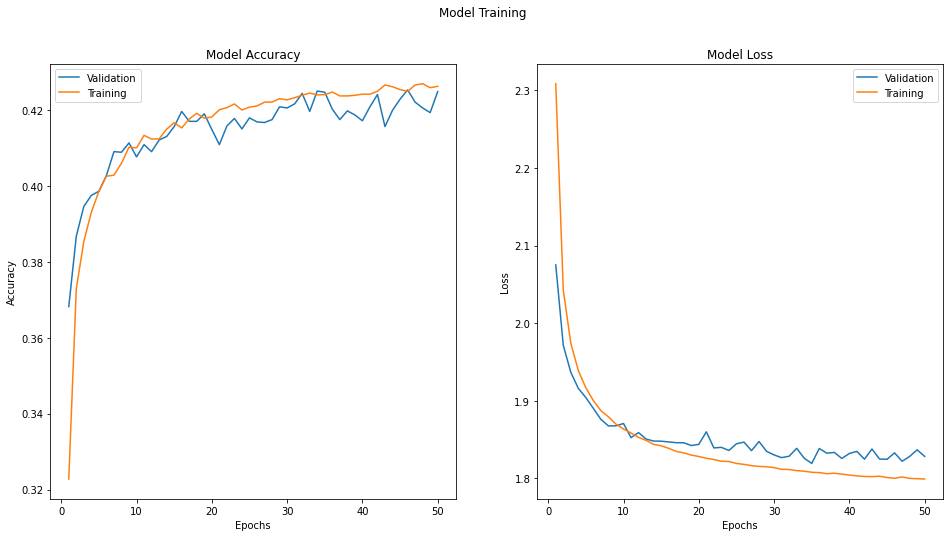

1.8325393199920654
0.4200122654438019
Test Accuracy: 42.00
128/128 [==============================] - 105s 822ms/step


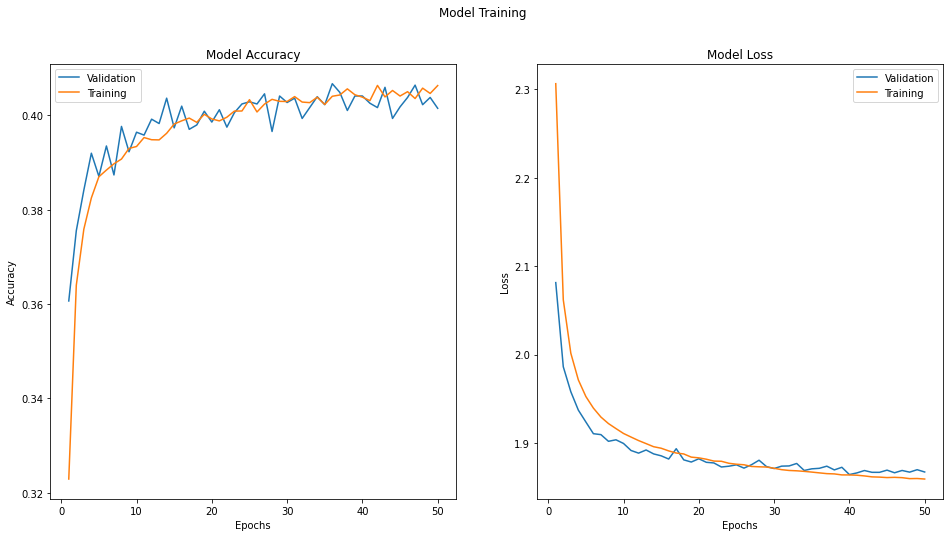

1.896916389465332
0.39883363246917725
Test Accuracy: 39.88
128/128 [==============================] - 120s 937ms/step


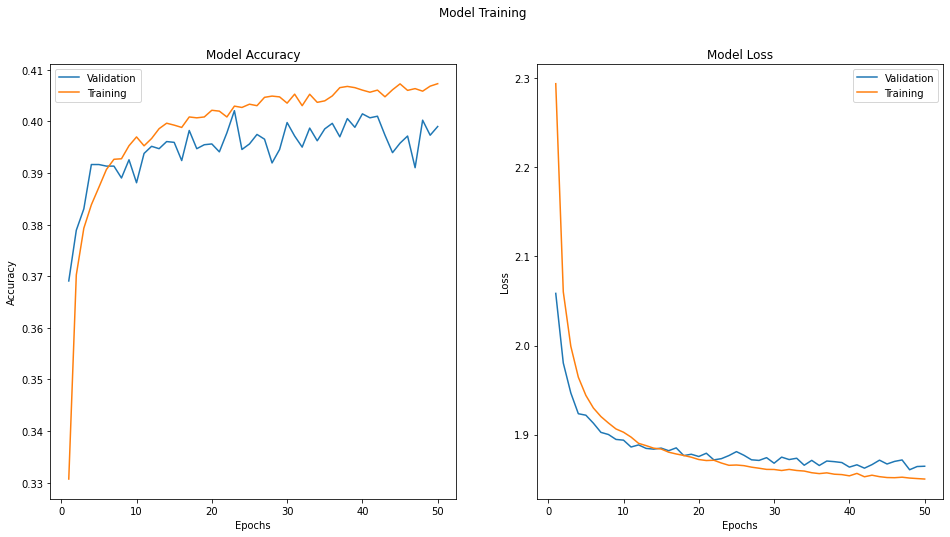

1.9016436338424683
0.3998158276081085
Test Accuracy: 39.98
128/128 [==============================] - 128s 1s/step


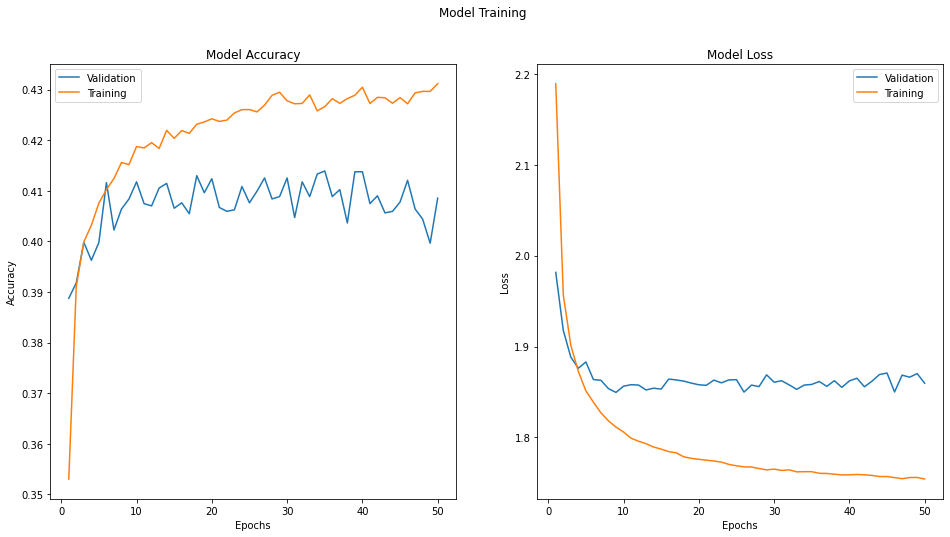

1.879138469696045
0.4103744626045227
Test Accuracy: 41.04


In [ ]:
resnet_stack_out_layers = [
  'conv2_block3_out','conv3_block4_out',
  'conv4_block6_out','conv5_block3_out'
]

for layer in resnet_stack_out_layers:
  tmp_encoder = model_depth_builder(encoder,layer)

  linear_eval(
    tmp_encoder,ds_train,ds_test,
    n_classes=label_encoder.classes_.shape[0],
    train_labels = y_train, test_labels= y_test 
  )